In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import networkx as nx
import pandas as pd
from icecream import ic

epinions_folder = "epinions/"
epinions_rating_path = epinions_folder + "rating.mat"
epinions_trust_path = epinions_folder + "trustnetwork.mat"

delicious_folder = "delicious/"
delicious_tagging_path = delicious_folder + "user_taggedbookmarks-timestamps.dat"
delicious_contacts_path = delicious_folder + "user_contacts-timestamps.dat"

# Data loading

## Epinions

In [2]:
# Load data
epinions_rating = sio.loadmat(epinions_rating_path)
epinions_rating = epinions_rating['rating']
# Convert to pandas dataframe
epinions_rating_df = pd.DataFrame(epinions_rating, columns=['user', 'item', 'category', 'rating'])
epinions_rating_df = epinions_rating_df.drop(['category'], axis=1)

# Load data
epinions_trust = sio.loadmat(epinions_trust_path)
epinions_trust = epinions_trust['trustnetwork']
# Convert to pandas dataframe
epinions_trust_df = pd.DataFrame(epinions_trust, columns=['user1', 'user2'])

## Delicious

In [3]:
# Load data and convert to pandas dataframe
delicious_tagging_df = pd.read_csv(delicious_tagging_path, sep='\t')
delicious_tagging_df = delicious_tagging_df.drop(['timestamp'], axis=1)
# Group by userID and bookmarkID and count the number of tags
delicious_tagging_df = delicious_tagging_df.groupby(['userID', 'bookmarkID']).size().reset_index(name='counts')
# Normalize the counts to be between 1 and 5 using rescaling
delicious_tagging_df['counts'] = delicious_tagging_df['counts'].apply(lambda x: 1 + (x-1)*(5-1)/(delicious_tagging_df['counts'].max()-delicious_tagging_df['counts'].min()))
delicious_tagging_df = delicious_tagging_df.rename(columns={'userID': 'user', 'bookmarkID': 'item', 'counts': 'rating'})

# Load data and convert to pandas dataframe
delicious_contacts_df = pd.read_csv(delicious_contacts_path, sep='\t')
delicious_contacts_df = delicious_contacts_df.drop(['timestamp'], axis=1)
delicious_contacts_df = delicious_contacts_df.rename(columns={'userID': 'user1', 'contactID': 'user2'})

In [4]:
print("Epinions rating shape: ", epinions_rating_df.shape)
print("Epinions rating head: \n", epinions_rating_df.head())

print("Epinions trust shape: ", epinions_trust_df.shape)
print("Epinions trust head: \n", epinions_trust_df.head())

print("Delicious tagging shape: ", delicious_tagging_df.shape)
print("Delicious tagging head: \n", delicious_tagging_df.head())

print("Delicious contacts shape: ", delicious_contacts_df.shape)
print("Delicious contacts head: \n", delicious_contacts_df.head())

Epinions rating shape:  (922267, 3)
Epinions rating head: 
    user  item  rating
0     1     1       2
1     1     2       2
2     1     3       2
3     1     4       5
4     1     5       3
Epinions trust shape:  (355754, 2)
Epinions trust head: 
    user1  user2
0  15373   9831
1   4247   9831
2   4644   9831
3   6823   9831
4   7479   9831
Delicious tagging shape:  (104799, 3)
Delicious tagging head: 
    user  item    rating
0     8     1  1.000000
1     8     2  1.000000
2     8     7  1.115942
3     8     8  1.115942
4     8     9  1.057971
Delicious contacts shape:  (15328, 2)
Delicious contacts head: 
    user1  user2
0      8  28371
1      8  40306
2      8  85279
3      8  91764
4      8  97723


# Statistical analysis

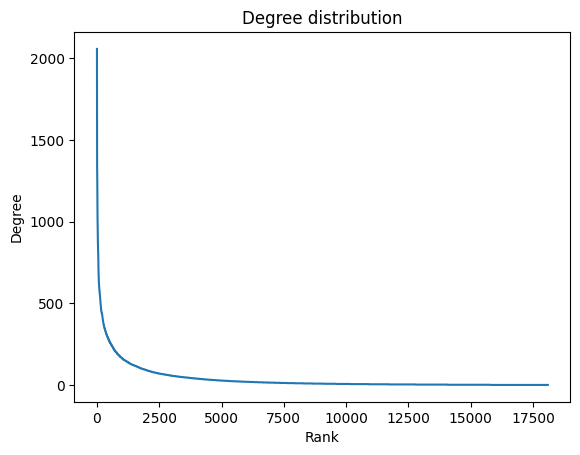

Metrics for trust epinions: 
 Number of users: 15451 
Number of links: 355754 
Average degree: 23.02465859814899 
Max out-degree: 1551 
Max in-degree: 2023 
Density: 0.0014902691649287371 
Transitivity: 0.121740032505204 
Number of components: 69 



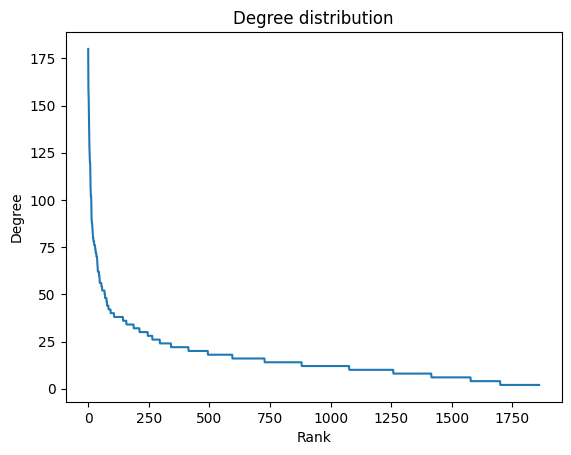

Metrics for trust delicious: 
 Number of users: 1861 
Number of links: 15328 
Average degree: 8.236432025792585 
Max out-degree: 90 
Max in-degree: 90 
Density: 0.0044281892611788085 
Transitivity: 0.41582336706531736 
Number of components: 62 



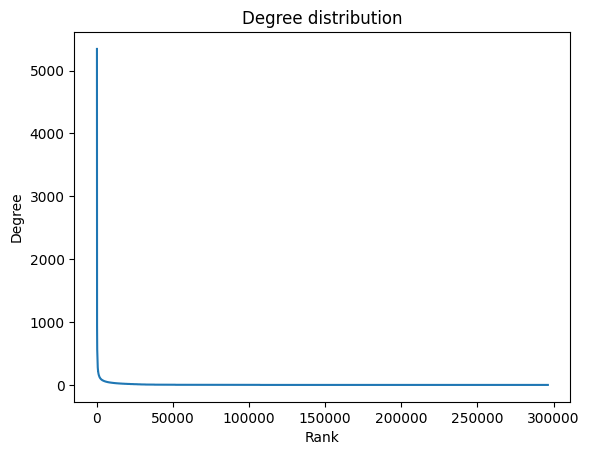

Metrics for rating epinions: 
 Number of users: 22164 
Number of items: 296277 
Number of ratings: 922267 
Average user degree: 41.61103591409493 
Average item degree: 3.1128538496069558 
 Max user degree: 5357 
 Max item degree: 1834 
Density: 0.00014044639278140028 
Number of components: 1 
Clustering coefficient: 0.0021274490862151427 
Assortativity: -0.1361776311346017 



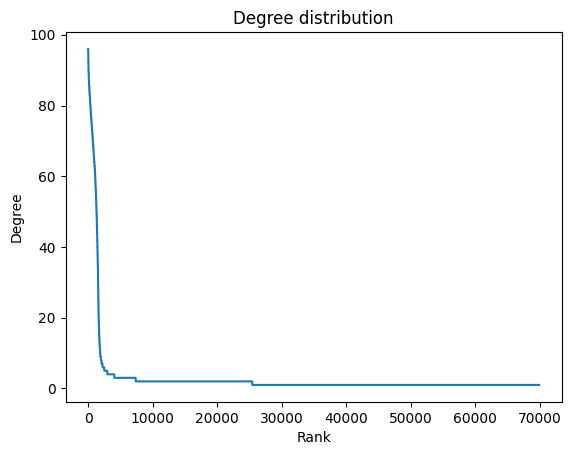

Metrics for rating delicious: 
 Number of users: 1867 
Number of items: 69223 
Number of ratings: 104799 
Average user degree: 56.13229780396358 
Average item degree: 1.513933230284732 
 Max user degree: 95 
 Max item degree: 29 
Density: 0.0008108908571423309 
Number of components: 12 
Clustering coefficient: 0.0011057622356465257 
Assortativity: -0.8499649954951622 



In [29]:
# Show caracteristics of the data

def degree_distribution(graph, name):
    degrees = [graph.degree(node) for node in graph.nodes()]
    degrees = np.array(degrees)
    degrees = degrees[degrees != 0]
    degrees = sorted(degrees, reverse=True)
    plt.plot(degrees)
    plt.xlabel('Rank')
    plt.ylabel('Degree')
    plt.title('Degree distribution')
    plt.savefig(f'{name}_degree_distrib.png')
    plt.show()

def metrics_4_trust(df, name):
    nb_users = df['user1'].nunique()
    nb_links = df.shape[0]
    avg_degree = nb_links / nb_users
    max_nb_trust = df.groupby(['user1']).size().max()
    max_nb_trusted = df.groupby(['user2']).size().max()

    density = nb_links / (nb_users * (nb_users - 1))

    graph = nx.from_pandas_edgelist(df, 'user1', 'user2', create_using=nx.DiGraph)

    transitivity = nx.transitivity(graph)
    nb_components = nx.number_weakly_connected_components(graph)

    degree_distribution(graph, name)    

    return f"Number of users: {nb_users} \nNumber of links: {nb_links} \nAverage degree: {avg_degree} \nMax out-degree: {max_nb_trust} \nMax in-degree: {max_nb_trusted} \nDensity: {density} \nTransitivity: {transitivity} \nNumber of components: {nb_components} \n"

def metrics_4_rating(df, name):
    nb_users = df['user'].nunique()
    nb_items = df['item'].nunique()
    nb_ratings = df.shape[0]
    avg_degree_user = nb_ratings / nb_users
    avg_degree_item = nb_ratings / nb_items
    max_nb_ratings_user = df.groupby(['user']).size().max()
    max_nb_ratings_item = df.groupby(['item']).size().max()

    density = nb_ratings / (nb_users * nb_items)

    graph = nx.Graph()
    graph.add_nodes_from(df['user'].unique(), bipartite=0)
    graph.add_nodes_from(df['item'].unique(), bipartite=1)
    graph.add_edges_from(df[['user', 'item']].values)

    clustering_coefficient = nx.average_clustering(graph)
    nb_components = nx.number_connected_components(graph)

    degree_distribution(graph, name)

    return f"Number of users: {nb_users} \nNumber of items: {nb_items} \nNumber of ratings: {nb_ratings} \nAverage user degree: {avg_degree_user} \nAverage item degree: {avg_degree_item} \n Max user degree: {max_nb_ratings_user} \n Max item degree: {max_nb_ratings_item} \nDensity: {density} \nNumber of components: {nb_components} \nClustering coefficient: {clustering_coefficient} \nAssortativity: {assortativity} \n"

metrics_4_trust_epinions = metrics_4_trust(epinions_trust_df, 'epinions_trust')
print("Metrics for trust epinions: \n", metrics_4_trust_epinions)

metrics_4_trust_delicious = metrics_4_trust(delicious_contacts_df, 'delicious_contacts')
print("Metrics for trust delicious: \n", metrics_4_trust_delicious)

metrics_4_rating_epinions = metrics_4_rating(epinions_rating_df, 'epinions_rating')
print("Metrics for rating epinions: \n", metrics_4_rating_epinions)

metrics_4_rating_delicious = metrics_4_rating(delicious_tagging_df, 'delicious_tagging')
print("Metrics for rating delicious: \n", metrics_4_rating_delicious)
    